<a href="https://colab.research.google.com/github/HarshaIndukuri/21cs460_group16/blob/main/U_Net_Crater_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#mounting google drive (data uploded there)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5

In [ ]:
#accessing moon images and masks from drive
train_images_path = r'/content/drive/MyDrive/Colab Notebooks/DEM and images/train_images.hdf5'
f = h5.File(train_images_path,'r')

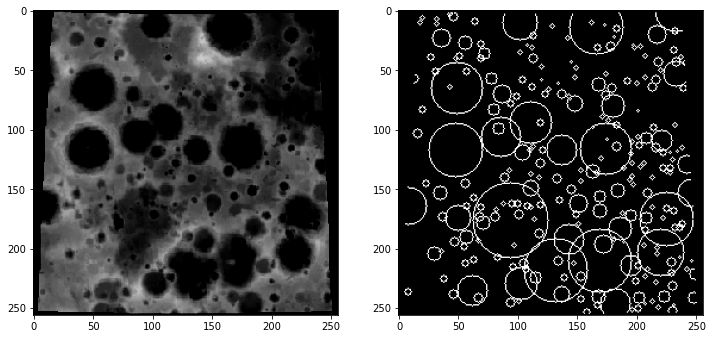

In [ ]:
#showing sample dem-target pair
fig = plt.figure(figsize=[12, 6])
[ax1, ax2] = fig.subplots(1,2)
ax1.imshow(f['input_images'][10][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][10][...], origin='upper', cmap='Greys_r')
plt.show()

In [ ]:
#converting hdf5 columns to numpy array and taking a portion as training set
#training set of of size 15000 images and masks
training_images = np.array(f['input_images'][:15000])
training_masks = np.array(f['target_masks'][:15000])

In [ ]:
#validation images and masks (picking 5000 images and masks)
valid_images = np.array(f['input_images'][20000:25000])
valid_masks =  np.array(f['target_masks'][20000:25000])

In [ ]:
#first import the functions we need from keras
from keras.models import Model
from keras.layers import BatchNormalization,Input
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPool2D
from keras.layers.merge import concatenate

Now we will implement the U-Net architecture prescribed in Silburt et al:
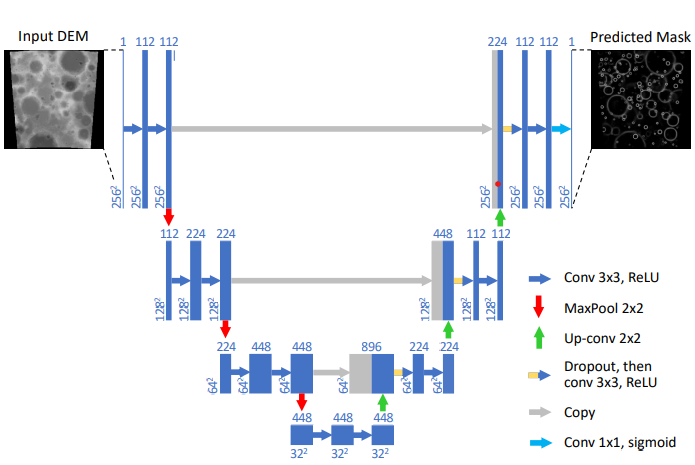

In [ ]:
#function that passes input through 2 3*3 conv layers used in contracting path of U-Net shown above
def uconv1(inputs,kernels):
    l = Conv2D(kernels,(3,3),activation = 'relu', padding = 'same')(inputs) 
    l = Conv2D(kernels,(3,3),activation = 'relu', padding = 'same')(l)
    l = BatchNormalization()(l) # adding batch normalization to ease training
    return l

#similar to above function, but dropout is included and will be used in expansive path of U-Net as indictated above
def uconv2(inputs,kernels):
  l = Dropout(0.15)(inputs)
  l = Conv2D(kernels,kernel_size = (3,3),activation='relu',padding='same')(l)
  l = Conv2D(kernels,(3,3),activation='relu',padding='same')(l)
  l = BatchNormalization()(l) # adding batch normalization to ease training
  return l

#function that combines pooling step and convolution step
def u_conv_and_pool(inputs,kernels):
    o = uconv1(inputs,kernels)
    p = MaxPool2D((2,2))(o)
    return o,p
    
#function to upsample images (using transpose convolution)    
def upsample(inputs,res_inputs,kernels):
    l = Conv2DTranspose(kernels,(3,3),strides = (2,2),padding = 'same')(inputs)
    l = concatenate([res_inputs,l])
    l = uconv2(l,kernels)
    return l
    
def make_unet(input_shape,k): #k is number of filters in first layer
    inputs = Input(shape = input_shape)
    
    res1, p1 = u_conv_and_pool(inputs, k) 
    res2, p2 = u_conv_and_pool(p1, 2*k)
    res3, p3 = u_conv_and_pool(p2, 4*k)

    middle =  uconv1(p3, 4*k)

    d1 = upsample(middle, res3, 4*k)
    d2 = upsample(d1, res2, 2*k)
    d3 = upsample(d2, res1, k)
    
    output = Conv2D(1, (1,1), padding="same", activation="sigmoid")(d3) #final output,using sigmoid as shown in figure
    
    model = Model(inputs,output,name='Crater_U_Net')
    return model  

In [ ]:
image_shape = (256,256,1)
k = 56 #as shown in figure above, first layer of has 112 filters but we are using half of them
unet = make_unet(image_shape,k)
unet.summary()

Model: "Crater_U_Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 256, 256, 56) 560         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 56) 28280       conv2d_15[0][0]                  
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 256, 256, 56) 224         conv2d_16[0][0]                  
_______________________________________________________________________________________

In [ ]:
#setting the loss we want to optimise our model with (using binary cross entropy because at the pixel level this problem is a two class classfication)
unet.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=[keras.metrics.BinaryAccuracy(threshold = 0.5)])

In [ ]:
valid_data = (valid_images,valid_masks)
history = unet.fit(x=training_images,y=training_masks,validation_data = valid_data,epochs = 1,batch_size = 10)

1500/1500 [==============================] - 30576s 20s/step - loss: 0.1267 - binary_accuracy: 0.9659 - val_loss: 0.0862 - val_binary_accuracy: 0.9717


In [ ]:
#predictions for test set(taking 5000 images as test set)
test_images = np.array(f['input_images'][15000:20000])
test_preds = unet.predict(test_images)

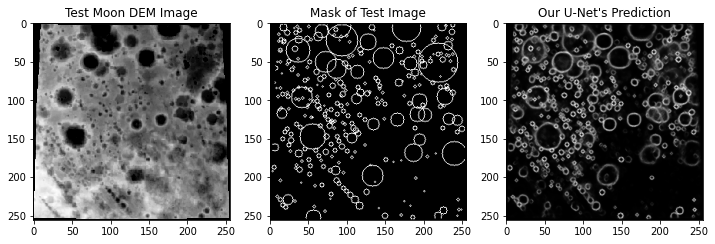

In [ ]:
#sample test image and mask, and u-net's prediction
test = test_preds[10]
test1 = test.reshape(256,256) #reshaping required
fig = plt.figure(figsize=[12, 6])
[ax1,ax2,ax3] = fig.subplots(1,3)
ax1.imshow(f['input_images'][15010][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][15010][...], origin='upper', cmap='Greys_r')
ax3.imshow(test1, origin='upper', cmap='Greys_r', vmin=0, vmax=1)
ax1.set_title('Test Moon DEM Image')
ax2.set_title('Mask of Test Image')
ax3.set_title("Our U-Net's Prediction")
plt.show()

The model is, atleast visually, doing very well. It trained on 15000 images for about 8.5 hours.The next bits of code are just for saving the trained model in my google drive and checking whether the saved model gives the same prediction as the one above.

In [ ]:
#saving trained model
unet.save('lunar_net.h5')

In [ ]:
#saving to drive also
import shutil
shutil.copy('/content/lunar_net.h5','/content/drive/MyDrive/trained models')

'/content/drive/MyDrive/trained models/lunar_net.h5'

In [ ]:
#checking if model is saved
reborn = keras.models.load_model('/content/drive/MyDrive/trained models/lunar_net.h5')
test_images2 = np.array(f['input_images'][15001:15011])
test_pred2 = reborn.predict(test_images2)

In [ ]:
test2 = test_pred2[9].reshape(256,256)

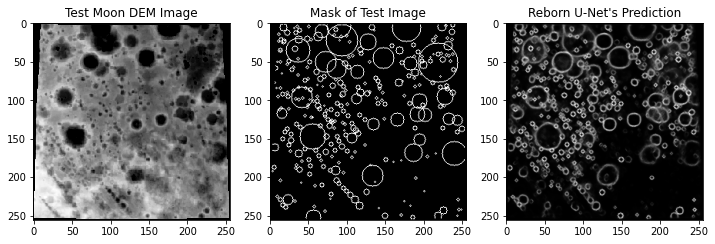

In [ ]:
fig = plt.figure(figsize=[12, 6])
[ax1,ax2,ax3] = fig.subplots(1,3)
ax1.imshow(f['input_images'][15010][...], origin='upper', cmap='Greys_r', vmin=120, vmax=200)
ax2.imshow(f['target_masks'][15010][...], origin='upper', cmap='Greys_r')
ax3.imshow(test2, origin='upper', cmap='Greys_r', vmin=0, vmax=1)
ax1.set_title('Test Moon DEM Image')
ax2.set_title('Mask of Test Image')
ax3.set_title("Reborn U-Net's Prediction")
plt.show()